In [76]:
import glob 
import os
import pandas as pd
import json

import matplotlib.pyplot as plt
import seaborn as sns

In [77]:
paths = glob.glob('results_hyper/flights-*run*.txt')

In [107]:
def extract_row(path):
    with open(path) as fp:
        lines = fp.readlines()

        sel = list(filter(lambda line: line.startswith('{"startupTime":'), lines))
        row = json.loads(sel[0])
        name = os.path.basename(path).replace('flights-', '')
        xq = name.split('-')
        run = xq[-1]
        
        mode = name.replace('flights-', '').replace('-run-', '').replace(run, '')
        
        run = int(run.replace('.txt', ''))
        row['mode'] = mode
        row['run'] = run
        row['path'] = path

        sel = list(filter(lambda line: 'LAMBDA compute took' in line, lines))[0]
        lam_compute = float(sel[sel.find('took ')+5:sel.rfind('s,')])
        row['lambdaComputeTime'] = lam_compute
        cost = float(sel[sel.find('cost $')+6:].strip())

        row['cost'] = cost
        
        
        # json part:
        json_path = 'results_hyper/flights-{}/job_{:04d}.json'.format(mode, run - 1)
        with open(json_path, 'r') as fp:
            data = json.load(fp)

            in_normal = data['input_paths_taken']['normal']
            in_general = data['input_paths_taken']['general']
            in_fallback = data['input_paths_taken']['fallback']
            in_unresolved = data['input_paths_taken']['unresolved']

            out_normal = data['output_paths_taken']['normal']
            out_unresolved = data['output_paths_taken']['unresolved']

            requests = data['requests']

            timings = dict(zip(['t_fast', 't_slow', 't_hyper', 't_compile', 't_fast_per_row'],
                            [0, 0, 0, 0, 0]))
            num_reqs_with_normal = 0
            for req in requests:
                for k in ['t_fast', 't_slow', 't_hyper', 't_compile']:
                    timings[k] += req.get(k, None)
                r_in_normal = req['input_paths_taken']['normal']
                if 0 != r_in_normal:
                    timings['t_fast_per_row'] += req['t_fast'] / r_in_normal
                    num_reqs_with_normal += 1

            row['in_normal'] = in_normal
            row['in_general'] = in_general
            row['in_fallback'] = in_fallback
            row['in_unresolved'] = in_unresolved
            row['out_normal'] = out_normal
            row['out_unresolved'] = out_unresolved

            row['cost'] = data['cost']

            timings['t_fast_per_row'] /= num_reqs_with_normal
            row.update(timings)
        

        return row


In [108]:
rows = []
for path in paths:
    rows.append(extract_row(path))
    
df = pd.DataFrame(rows)

In [109]:
# get rid off first run (warmup)
df = df[df['run'] != 1]

In [111]:
df[['mode', 'startupTime', 'jobTime', 'lambdaComputeTime', 'cost']].sort_values(by='jobTime').groupby('mode').agg(['mean', 'std']).reset_index()

mode startupTime              jobTime           lambdaComputeTime  \
                       mean       std       mean       std              mean   
0         hyper    0.215946  0.012409  16.213777  2.570143         12.427710   
1    hyper-nocf    0.221569  0.035831  15.672760  1.504990         11.946368   
2       nohyper    0.209959  0.009860  15.807922  4.504160         11.397159   
3  nohyper-nocf    0.215720  0.014130  15.573807  1.049915         11.214679   

                 cost            
        std      mean       std  
0  2.553732  0.385804  0.002033  
1  1.452487  0.373692  0.001674  
2  4.486150  0.317091  0.002748  
3  1.087565  0.316150  0.003158

Text(0, 0.5, 'end-to-end time in s')

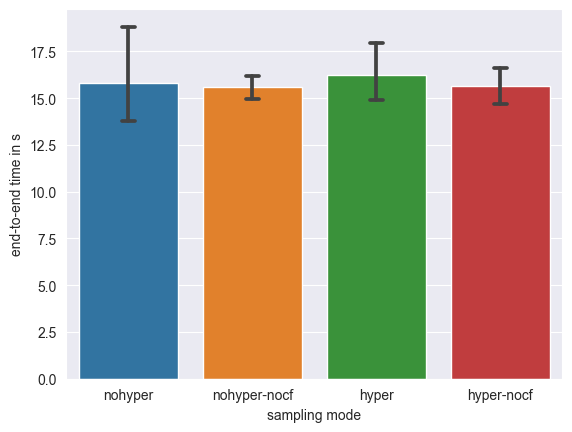

In [82]:
sns.set_style('darkgrid')
sns.barplot(data=df, x='mode', y='jobTime', capsize=0.1)
plt.xlabel('sampling mode')
plt.ylabel('end-to-end time in s')

Text(0, 0.5, '#normal rows')

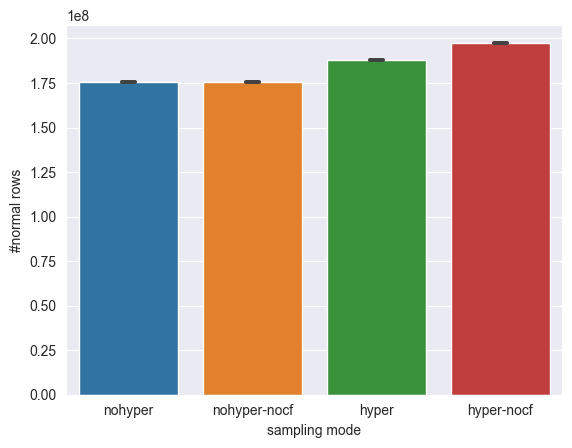

In [83]:
sns.set_style('darkgrid')
sns.barplot(data=df, x='mode', y='in_normal', capsize=0.1)
plt.xlabel('sampling mode')
plt.ylabel('#normal rows')

Text(0, 0.5, '#general rows')

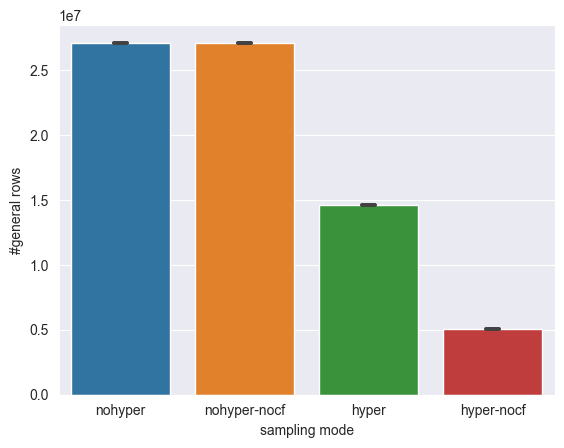

In [84]:
sns.set_style('darkgrid')
sns.barplot(data=df, x='mode', y='in_general', capsize=0.1)
plt.xlabel('sampling mode')
plt.ylabel('#general rows')

Text(0, 0.5, '#fallback rows')

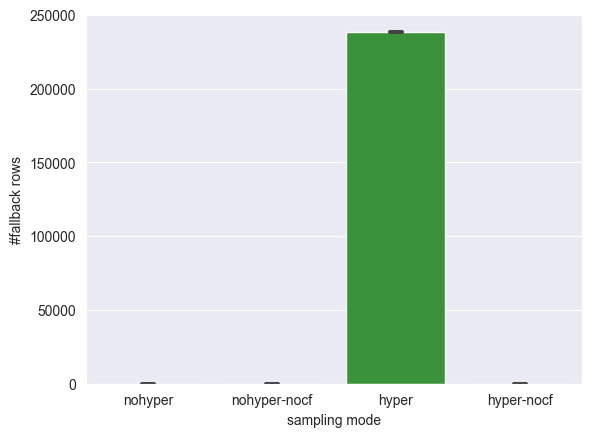

In [85]:
sns.set_style('darkgrid')
sns.barplot(data=df, x='mode', y='in_fallback', capsize=0.1)
plt.xlabel('sampling mode')
plt.ylabel('#fallback rows')

(1300.0, 1420.0)

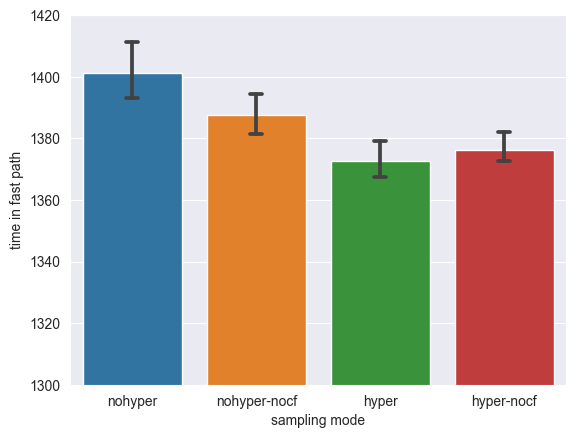

In [99]:
sns.set_style('darkgrid')
sns.barplot(data=df, x='mode', y='t_fast', capsize=0.1)
plt.xlabel('sampling mode')
plt.ylabel('time in fast path')
plt.ylim(1300, 1420)

Text(0, 0.5, 'time in slow (general + interpreter) path')

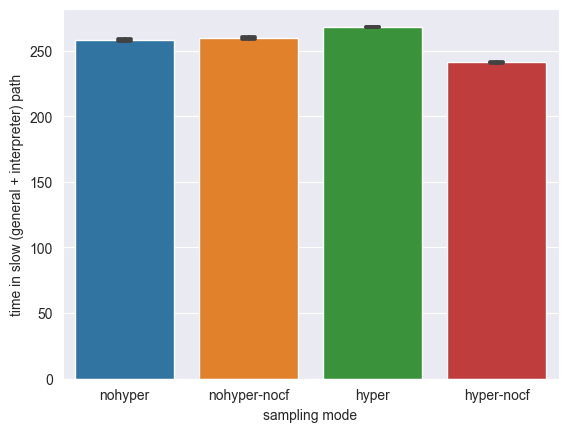

In [87]:
sns.set_style('darkgrid')
sns.barplot(data=df, x='mode', y='t_slow', capsize=0.1)
plt.xlabel('sampling mode')
plt.ylabel('time in slow (general + interpreter) path')

Text(0, 0.5, 'time spend compiling')

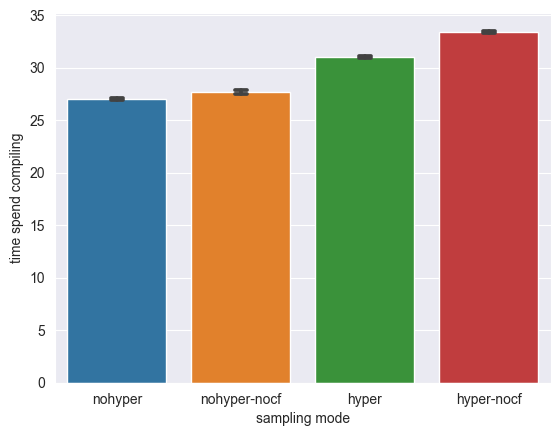

In [88]:
sns.set_style('darkgrid')
sns.barplot(data=df, x='mode', y='t_compile', capsize=0.1)
plt.xlabel('sampling mode')
plt.ylabel('time spend compiling')

Text(0, 0.5, 'time spend hyperspecializing')

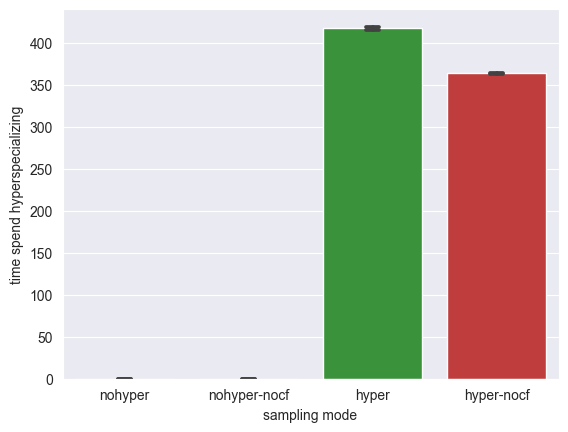

In [89]:
sns.set_style('darkgrid')
sns.barplot(data=df, x='mode', y='t_hyper', capsize=0.1)
plt.xlabel('sampling mode')
plt.ylabel('time spend hyperspecializing')

Text(0, 0.5, 'cost per query in $ (USD)')

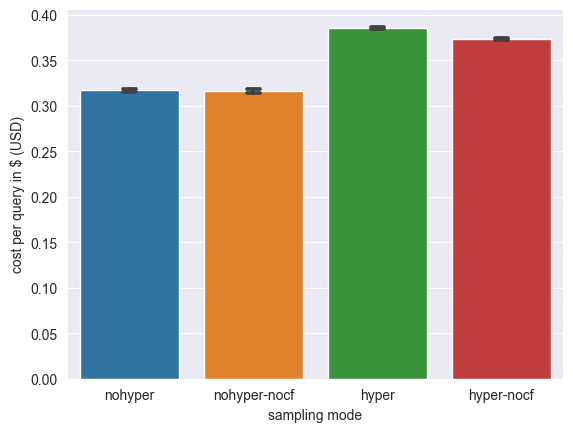

In [90]:
sns.set_style('darkgrid')
sns.barplot(data=df, x='mode', y='cost', capsize=0.1)
plt.xlabel('sampling mode')
plt.ylabel('cost per query in $ (USD)')

Text(0, 0.5, 'query cost in $')

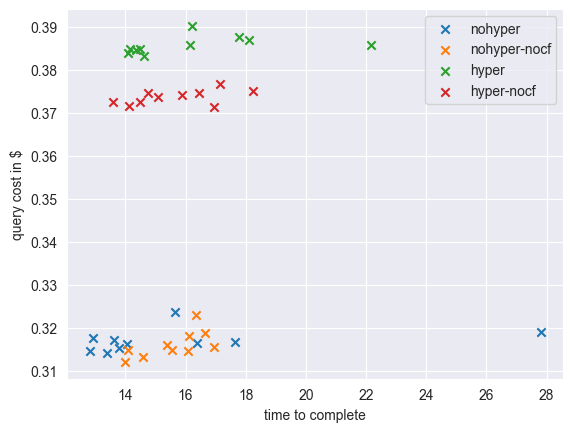

In [91]:
import itertools
marker = itertools.cycle(('x', 'v', '^', ',', '+', '>', 'o', '<')) 
marker = itertools.cycle(('x')) 
for i, mode in enumerate(df['mode'].unique()):
    plt.scatter(df[df['mode'] == mode]['jobTime'], 
                df[df['mode'] == mode]['cost'], label=mode, 
               marker=next(marker))
plt.legend()
#plt.ylim(0, 0.6)
#plt.xlim(0, 60)
plt.xlabel('time to complete')
plt.ylabel('query cost in $')

In [26]:
# what about the compute times?

In [41]:
for mode in df['mode'].unique():
    json_root_path = f'results_hyper/flights-{mode}'
    print(json_root_path)
    
    paths = glob.glob(json_root_path + '/*.json')
    for path in paths:
        name = os.path.basename(path)
        xq = name.split('_')
        run = xq[-1]
        run = int(run.replace('.json', ''))
        print(run)

results_hyper/flights-hyper
1
0
3
2
results_hyper/flights-nohyper-nocf
1
0
3
2
results_hyper/flights-hyper-nocf
1
0
3
2
results_hyper/flights-nohyper
1
0
3
2


In [36]:
paths

['results_hyper/flights-nohyper/job_0001.json',
 'results_hyper/flights-nohyper/job_0000.json',
 'results_hyper/flights-nohyper/job_0003.json',
 'results_hyper/flights-nohyper/job_0002.json']

In [37]:
!ls results_hyper

flights-hyper                         flights-nohyper
flights-hyper-nocf                    flights-nohyper-nocf
flights-hyper-nocf-run-1.json         flights-nohyper-nocf-run-1.json
flights-hyper-nocf-run-1.txt          flights-nohyper-nocf-run-1.txt
flights-hyper-nocf-run-1.txt.stderr   flights-nohyper-nocf-run-1.txt.stderr
flights-hyper-nocf-run-2.json         flights-nohyper-nocf-run-2.json
flights-hyper-nocf-run-2.txt          flights-nohyper-nocf-run-2.txt
flights-hyper-nocf-run-2.txt.stderr   flights-nohyper-nocf-run-2.txt.stderr
flights-hyper-nocf-run-3.json         flights-nohyper-nocf-run-3.json
flights-hyper-nocf-run-3.txt          flights-nohyper-nocf-run-3.txt
flights-hyper-nocf-run-3.txt.stderr   flights-nohyper-nocf-run-3.txt.stderr
flights-hyper-nocf-run-4.json         flights-nohyper-nocf-run-4.json
flights-hyper-nocf-run-4.txt          flights-nohyper-nocf-run-4.txt
flights-hyper-nocf-run-4.txt.stderr   flights-nohyper-nocf-run-4.txt.stderr
flights-hyper-run-1.json   

In [94]:
json_path = 'results_hyper/flights-hyper/job_0005.json'
with open(json_path, 'r') as fp:
    data = json.load(fp)

In [102]:
data['tasks'][0]['log'].split('\n')

['[2022-12-06 04:21:40.970] [Lambda worker] [info] performing global initialization (Worker App)',
 '[2022-12-06 04:21:40.975] [Lambda worker] [info] Invoking WorkerApp fallback',
 '[2022-12-06 04:21:40.977] [Lambda worker] [info] Found 1 input URIs to process',
 '[2022-12-06 04:21:40.977] [Lambda worker] [info] *** hyperspecialization active ***',
 '[2022-12-06 04:21:40.977] [Lambda worker] [info] -- specializing to s3://tuplex-public/data/flights_all/flights_on_time_performance_1987_11.csv:0-175988103',
 '[2022-12-06 04:21:40.977] [hyper specializer] [info] specializing code to file s3://tuplex-public/data/flights_all/flights_on_time_performance_1987_11.csv:0-175988103',
 '[2022-12-06 04:21:40.978] [hyper specializer] [info] Decompressed Code context from 9.40 KB to 88.30 KB',
 '[2022-12-06 04:21:41.012] [hyper specializer] [info] Deserialization of Code context took 0.034443s',
 '[2022-12-06 04:21:41.012] [hyper specializer] [info] Total Stage Decode took 0.035205s',
 '[2022-12-06 0